In [6]:
%pip install pandas
%pip install scikit-learn
%pip install Pillow
%pip install keras
%pip install matplotlib
%pip install numpy
%pip install opencv-python
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import (
    MobileNet,
    Xception,
    ResNet50V2,
    DenseNet201,
    DenseNet169,
    InceptionV3,
    InceptionResNetV2,
)
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

2024-07-15 18:41:29.058377: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-15 18:41:29.115119: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-15 18:41:29.374424: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-15 18:41:31.915070: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [8]:
# Load the datasets
base_dir = "./aptos2019-blindness-detection"
train_df = pd.read_csv(f"{base_dir}/train.csv")
test_df = pd.read_csv(f"{base_dir}/test.csv")

In [9]:
# Preprocessing functions
def crop_image_from_gray(img, tol=7):
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1), mask.any(0))]
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        if img[:, :, 0][np.ix_(mask.any(1), mask.any(0))].shape[0] == 0:
            return img
        else:
            img1 = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))]
            img2 = img[:, :, 1][np.ix_(mask.any(1), mask.any(0))]
            img3 = img[:, :, 2][np.ix_(mask.any(1), mask.any(0))]
            img = np.stack([img1, img2, img3], axis=-1)
        return img

def circle_crop(img, sigmaX=30):
    img = crop_image_from_gray(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width, depth = img.shape
    x = int(width / 2)
    y = int(height / 2)
    r = np.amin((x, y))
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x, y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0, 0), sigmaX), -4, 128)
    return img

def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = crop_image_from_gray(img)
    img = circle_crop(img)
    img = cv2.resize(img, (224, 224))
    return img

In [10]:
# Apply preprocessing to the dataset
train_df["file_path"] = train_df["id_code"].apply(
    lambda x: f"{base_dir}/train_images/{x}.png"
)
train_df["processed_image"] = train_df["file_path"].apply(preprocess_image)

test_df["file_path"] = test_df["id_code"].apply(
    lambda x: f"{base_dir}/test_images/{x}.png"
)
test_df["processed_image"] = test_df["file_path"].apply(preprocess_image)

# Split the training data into train and validation sets
train_df, val_df = train_test_split(
    train_df, test_size=0.2, stratify=train_df["diagnosis"]
)

train_df['diagnosis'] = train_df['diagnosis'].astype(str)
val_df['diagnosis'] = val_df['diagnosis'].astype(str)

In [11]:
# Data augmentation
# ImageDataGenerator for training with augmentation and validation without augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

# Define constants
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 32

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',
    y_col='diagnosis',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='file_path',
    y_col='diagnosis',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col=None,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False
)

Found 2929 validated image filenames belonging to 5 classes.


Found 733 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames.


In [12]:
EPOCHS = 20

# Define a function to create the model
def create_model(base_model, input_shape=(224, 224, 3)):
    model = Sequential(
        [
            base_model,
            Flatten(),
            Dense(256, activation="relu"),
            Dropout(0.5),
            Dense(5, activation="softmax"),
        ]
    )
    return model

# Function to evaluate the model
def evaluate_model(model, val_generator):
    # Predicting on the validation data
    val_generator.reset()
    val_preds = model.predict(val_generator, steps=len(val_generator), verbose=1)
    val_pred_classes = np.argmax(val_preds, axis=1)
    
    # True labels
    val_true_classes = val_generator.classes

    # Calculate metrics
    accuracy = accuracy_score(val_true_classes, val_pred_classes)
    precision = precision_score(val_true_classes, val_pred_classes, average='weighted')
    recall = recall_score(val_true_classes, val_pred_classes, average='weighted')
    f1 = f1_score(val_true_classes, val_pred_classes, average='weighted')
    conf_matrix = confusion_matrix(val_true_classes, val_pred_classes)
    class_report = classification_report(val_true_classes, val_pred_classes)
    
    return accuracy, precision, recall, f1, conf_matrix, class_report

# Plotting training history
def plot_history(history, model_name):
    plt.figure(figsize=(12, 4))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# List of models to train
models = [
    (
        "MobileNet",
        MobileNet(weights="imagenet", include_top=False, input_shape=(224, 224, 3)),
    ),
    (
        "Xception",
        Xception(weights="imagenet", include_top=False, input_shape=(224, 224, 3)),
    ),
    (
        "ResNet50V2",
        ResNet50V2(weights="imagenet", include_top=False, input_shape=(224, 224, 3)),
    ),
    (
        "DenseNet201",
        DenseNet201(weights="imagenet", include_top=False, input_shape=(224, 224, 3)),
    ),
    (
        "DenseNet169",
        DenseNet169(weights="imagenet", include_top=False, input_shape=(224, 224, 3)),
    ),
    (
        "InceptionV3",
        InceptionV3(weights="imagenet", include_top=False, input_shape=(224, 224, 3)),
    ),
    (
        "InceptionResNetV2",
        InceptionResNetV2(
            weights="imagenet", include_top=False, input_shape=(224, 224, 3)
        ),
    ),
]

Training MobileNet model...
Epoch 1/20


2024-07-15 20:14:10.688661: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51380224 exceeds 10% of free system memory.
2024-07-15 20:14:10.715677: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51380224 exceeds 10% of free system memory.
2024-07-15 20:14:10.852391: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51380224 exceeds 10% of free system memory.
2024-07-15 20:14:10.905993: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51380224 exceeds 10% of free system memory.
2024-07-15 20:14:10.957864: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51380224 exceeds 10% of free system memory.
/home/rakib/Desktop/Thesis/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multipr

91/91 ━━━━━━━━━━━━━━━━━━━━ 1200s 13s/step - accuracy: 0.5598 - loss: 8.3554 - val_accuracy: 0.5043 - val_loss: 5.9513
Epoch 2/20
 1/91 ━━━━━━━━━━━━━━━━━━━━ 18:13 12s/step - accuracy: 0.6250 - loss: 1.0342

2024-07-15 20:34:08.835547: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


91/91 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.6250 - loss: 1.0342 - val_accuracy: 0.4483 - val_loss: 4.4348
Epoch 3/20


2024-07-15 20:34:10.528090: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-15 20:34:24.584276: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3 of 8
2024-07-15 20:34:44.128250: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2024-07-15 20:34:48.713942: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


91/91 ━━━━━━━━━━━━━━━━━━━━ 1221s 13s/step - accuracy: 0.6481 - loss: 0.9798 - val_accuracy: 0.5256 - val_loss: 2.2313
Epoch 4/20
 1/91 ━━━━━━━━━━━━━━━━━━━━ 19:34 13s/step - accuracy: 0.6562 - loss: 0.8404

2024-07-15 20:54:44.597556: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


91/91 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.6562 - loss: 0.8404 - val_accuracy: 0.7241 - val_loss: 1.6217
Epoch 5/20


2024-07-15 20:54:46.501243: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-15 20:55:45.936417: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3 of 8
2024-07-15 20:56:04.171329: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2024-07-15 20:56:09.002256: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


91/91 ━━━━━━━━━━━━━━━━━━━━ 1232s 13s/step - accuracy: 0.6869 - loss: 0.8726 - val_accuracy: 0.6207 - val_loss: 1.4049
Epoch 6/20
 1/91 ━━━━━━━━━━━━━━━━━━━━ 16:31 11s/step - accuracy: 0.6875 - loss: 0.7732

2024-07-15 21:15:30.014647: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


91/91 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.6875 - loss: 0.7732 - val_accuracy: 0.6897 - val_loss: 0.6991
Epoch 7/20


2024-07-15 21:15:31.696073: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-15 21:16:07.916580: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3 of 8
2024-07-15 21:16:28.750369: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


91/91 ━━━━━━━━━━━━━━━━━━━━ 1223s 13s/step - accuracy: 0.7261 - loss: 0.8045 - val_accuracy: 0.7315 - val_loss: 0.9046
Epoch 8/20
 1/91 ━━━━━━━━━━━━━━━━━━━━ 18:03 12s/step - accuracy: 0.7812 - loss: 0.6311

2024-07-15 21:36:06.646757: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


91/91 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.7812 - loss: 0.6311 - val_accuracy: 0.6897 - val_loss: 0.9301
Epoch 9/20


2024-07-15 21:36:08.567465: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-15 21:36:19.446606: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2 of 8
2024-07-15 21:36:42.787625: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2024-07-15 21:36:47.397401: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


91/91 ━━━━━━━━━━━━━━━━━━━━ 1224s 13s/step - accuracy: 0.7353 - loss: 0.6987 - val_accuracy: 0.7457 - val_loss: 0.7293
Epoch 10/20
 1/91 ━━━━━━━━━━━━━━━━━━━━ 16:39 11s/step - accuracy: 0.6875 - loss: 0.6916

2024-07-15 21:56:43.574758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


91/91 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.6875 - loss: 0.6916 - val_accuracy: 0.7586 - val_loss: 1.0254
Epoch 11/20


2024-07-15 21:56:45.191028: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-15 21:56:57.759742: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3 of 8
2024-07-15 21:57:16.271321: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2024-07-15 21:57:21.209624: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


91/91 ━━━━━━━━━━━━━━━━━━━━ 1224s 13s/step - accuracy: 0.7411 - loss: 0.6631 - val_accuracy: 0.7528 - val_loss: 0.7582
Epoch 12/20
 1/91 ━━━━━━━━━━━━━━━━━━━━ 18:26 12s/step - accuracy: 0.7500 - loss: 0.8545

2024-07-15 22:17:21.706326: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


91/91 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.7500 - loss: 0.8545 - val_accuracy: 0.8276 - val_loss: 0.6235
Epoch 13/20


2024-07-15 22:17:23.635367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-15 22:17:37.017781: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3 of 8
2024-07-15 22:17:57.855108: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


91/91 ━━━━━━━━━━━━━━━━━━━━ 1230s 13s/step - accuracy: 0.7511 - loss: 0.6799 - val_accuracy: 0.6293 - val_loss: 1.2592
Epoch 14/20
 1/91 ━━━━━━━━━━━━━━━━━━━━ 17:17 12s/step - accuracy: 0.7188 - loss: 0.6950

2024-07-15 22:38:05.033610: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


91/91 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7188 - loss: 0.6950 - val_accuracy: 0.6897 - val_loss: 0.9184
Epoch 15/20


2024-07-15 22:38:06.764295: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-15 22:38:17.085338: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2 of 8
2024-07-15 22:38:31.234539: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 5 of 8
2024-07-15 22:38:45.281592: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


91/91 ━━━━━━━━━━━━━━━━━━━━ 1232s 13s/step - accuracy: 0.7552 - loss: 0.6883 - val_accuracy: 0.6477 - val_loss: 1.8180
Epoch 16/20
 1/91 ━━━━━━━━━━━━━━━━━━━━ 16:44 11s/step - accuracy: 0.7812 - loss: 0.6493

2024-07-15 22:58:49.843214: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


91/91 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7812 - loss: 0.6493 - val_accuracy: 0.7931 - val_loss: 0.6366
Epoch 17/20


2024-07-15 22:58:51.571289: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-15 22:59:05.795110: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3 of 8
2024-07-15 22:59:23.342981: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2024-07-15 22:59:27.442375: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


91/91 ━━━━━━━━━━━━━━━━━━━━ 1229s 13s/step - accuracy: 0.7462 - loss: 0.6830 - val_accuracy: 0.7330 - val_loss: 0.8703
Epoch 18/20
 1/91 ━━━━━━━━━━━━━━━━━━━━ 18:35 12s/step - accuracy: 0.8750 - loss: 0.3486

2024-07-15 23:19:32.788688: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


91/91 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.8750 - loss: 0.3486 - val_accuracy: 0.6552 - val_loss: 0.9655
Epoch 19/20


2024-07-15 23:19:34.673942: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-15 23:19:48.617595: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3 of 8
2024-07-15 23:20:06.853816: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2024-07-15 23:20:13.037305: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


91/91 ━━━━━━━━━━━━━━━━━━━━ 1242s 13s/step - accuracy: 0.7508 - loss: 0.5915 - val_accuracy: 0.7827 - val_loss: 0.5969
Epoch 20/20
 1/91 ━━━━━━━━━━━━━━━━━━━━ 16:48 11s/step - accuracy: 0.8750 - loss: 0.4433

2024-07-15 23:40:28.448315: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


91/91 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.8750 - loss: 0.4433 - val_accuracy: 0.6897 - val_loss: 1.0136


2024-07-15 23:40:30.177984: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Evaluating MobileNet model...
23/23 ━━━━━━━━━━━━━━━━━━━━ 121s 5s/step


/home/rakib/Desktop/Thesis/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rakib/Desktop/Thesis/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rakib/Desktop/Thesis/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

Accuracy: 0.3478854024556617
Precision: 0.33006403637013815
Recall: 0.3478854024556617
F1 Score: 0.3351779733553713
Confusion Matrix:
 [[173  22 155   0  11]
 [ 35   4  30   0   5]
 [ 94  20  74   0  12]
 [ 18   5  14   0   2]
 [ 28   6  21   0   4]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.48      0.49       361
           1       0.07      0.05      0.06        74
           2       0.25      0.37      0.30       200
           3       0.00      0.00      0.00        39
           4       0.12      0.07      0.09        59

    accuracy                           0.35       733
   macro avg       0.19      0.19      0.19       733
weighted avg       0.33      0.35      0.34       733



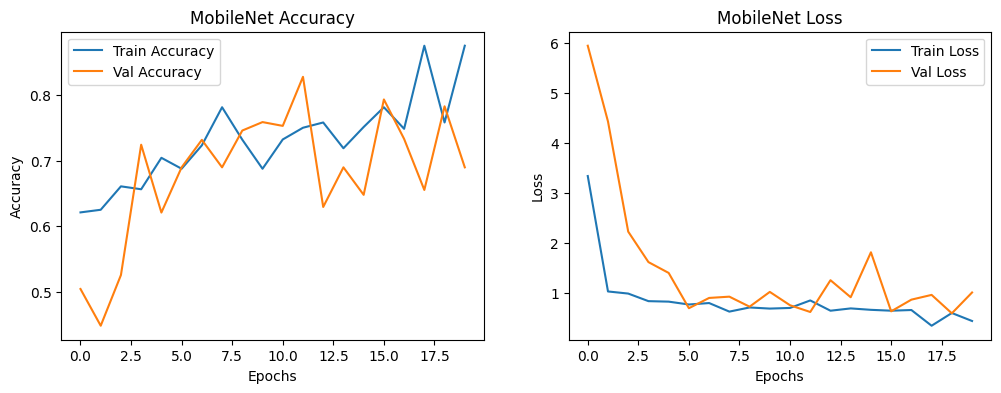

Training Xception model...
Epoch 1/20


2024-07-15 23:44:24.386403: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:36: Filling up shuffle buffer (this may take a while): 3 of 8
2024-07-15 23:44:43.684653: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:36: Filling up shuffle buffer (this may take a while): 7 of 8
2024-07-15 23:44:48.793413: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


10/91 ━━━━━━━━━━━━━━━━━━━━ 52:44 39s/step - accuracy: 0.3477 - loss: 4.9203

KeyboardInterrupt: 

In [13]:
# Training each model and evaluating
for model_name, base_model in models:
    model = create_model(base_model)
    model.compile(
        optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"]
    )

    print(f"Training {model_name} model...")
    
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_df) // BATCH_SIZE,
        validation_data=val_generator,
        validation_steps=len(val_df) // BATCH_SIZE,
        epochs=EPOCHS,
    )

    model.save(f"{model_name}_model.h5")

    # Evaluate the model
    print(f"Evaluating {model_name} model...")
    accuracy, precision, recall, f1, conf_matrix, class_report = evaluate_model(model, val_generator)
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Confusion Matrix:\n {conf_matrix}")
    print(f"Classification Report:\n {class_report}")

    # Plot training history
    plot_history(history, model_name)